# Understand Open Pose

In this notebook we just play around with open pose, look at heatmaps and peaks

In [89]:
%load_ext autoreload
%autoreload 2
# imports
import logging
import os
import sys

sys.path.insert(0, os.path.abspath('..'))
sys.path.insert(0, os.path.abspath('../..'))

import cv2
import nest_asyncio
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D

from deepexplain.tf.v1_x import DeepExplain
from plot_utils import plot_pose
from tf_pose import common
from tf_pose.common import CocoPart
from tf_pose.estimator import TfPoseEstimator
from tf_pose.networks import get_graph_path
from tf_pose.tensblur.smoother import Smoother
from plot_utils import plot, plt, plot_humans_lines, plot_human_lines
from utils import get_humans_as_lines
import seaborn as sns


# Import DeepExplain

nest_asyncio.apply()

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
logging.getLogger("tensorflow").setLevel(logging.CRITICAL)
logging.getLogger('TfPoseEstimatorRun').setLevel(logging.ERROR)
logging.getLogger('DeepExplain').setLevel(logging.ERROR)
logging.getLogger('TfPoseEstimator').setLevel(logging.ERROR)
print(cv2.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
4.1.0


In [78]:
# params 432, 368
w, h = 432, 368
image_path = '../data/images/ballet_woman_man_dance_dancer-145734.jpg'
image_path_black = '../data/images/ballet_occ.jpg'
model = 'cmu'
resize_out_ratio = 2.0
image_orig_size = common.read_imgfile(image_path)
image = common.read_imgfile(image_path, w, h)
image_black = common.read_imgfile(image_path_black, w, h)
ATTRIBUTION_PART = CocoPart.RElbow.value

In [79]:
e = TfPoseEstimator(get_graph_path(model), target_size=(w, h), trt_bool=False)
e_black = TfPoseEstimator(get_graph_path(model), target_size=(w, h), trt_bool=False)

In [80]:
# compute with and without
humans = e.inference(image, resize_to_default=(
    w > 0 and h > 0), upsample_size=resize_out_ratio)
humans_black = e_black.inference(image_black, resize_to_default=(
    w > 0 and h > 0), upsample_size=resize_out_ratio)

In [81]:
part = humans[0].body_parts[ATTRIBUTION_PART]
print(f'ORIG: score: {part.score} x: {part.x} y: {part.y} ')
part = humans_black[0].body_parts[ATTRIBUTION_PART]
print(f'OCCULED: score: {part.score} x: {part.x} y: {part.y} ')

ORIG: score: 0.8034953474998474 x: 0.2962962962962963 y: 0.17391304347826086 
OCCULED: score: 0.6527618169784546 x: 0.2962962962962963 y: 0.18478260869565216 


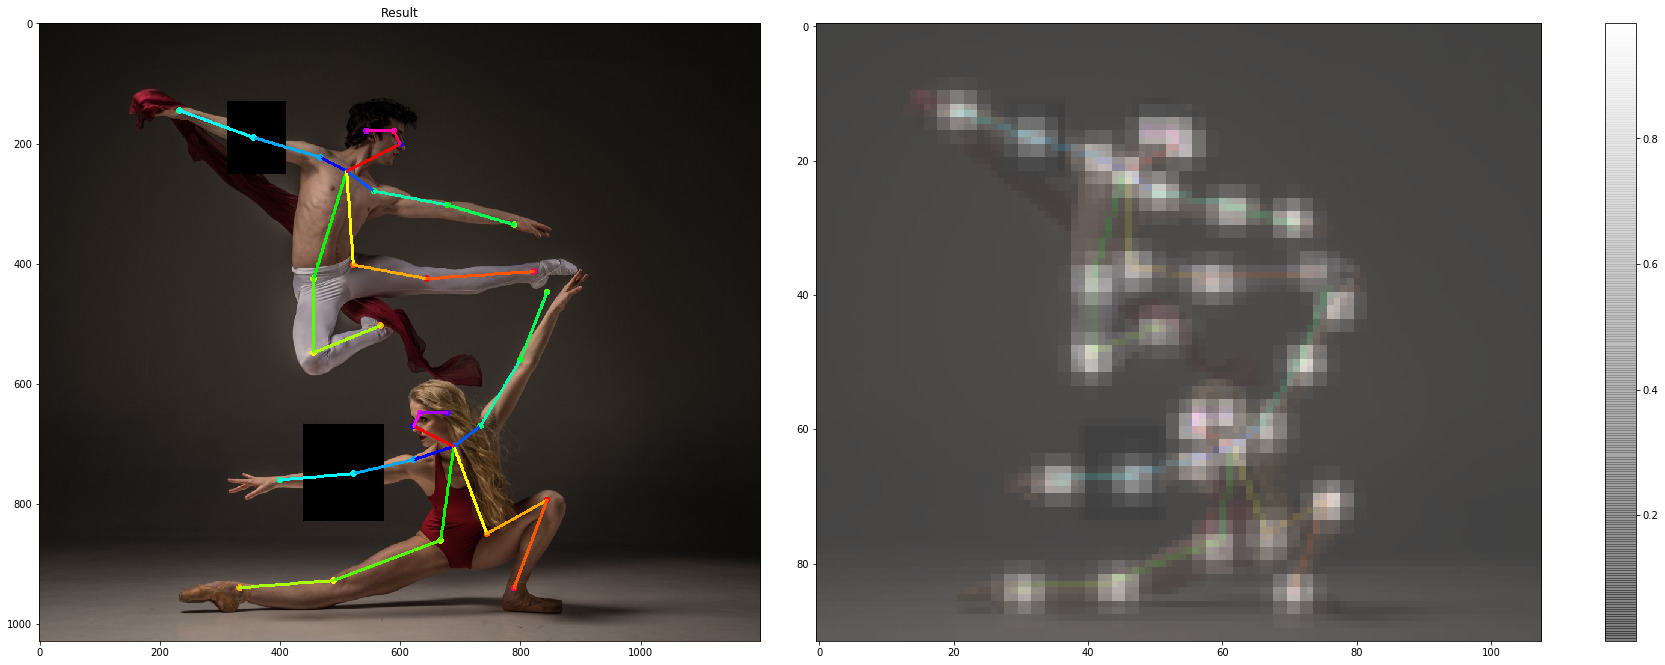

In [58]:
# estimate human poses from a single image !
humans_orig = e.inference(image, resize_to_default=(
    w > 0 and h > 0), upsample_size=resize_out_ratio)
# run again with parameters passed
plot_pose(image_orig_size, humans_orig, e.heatMat)

In [74]:
# save Pose 
image_result = TfPoseEstimator.draw_humans(image_orig_size, humans_orig, imgcopy=True)
cv2.imwrite('../results/plots/ballet_with_pose_occ.png', image_result)

True

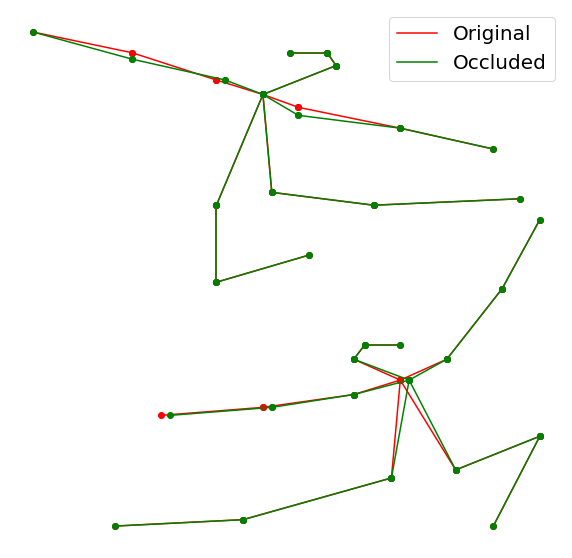

In [91]:
humans_lines = get_humans_as_lines(humans, 400, 450)
humans_black_lines = get_humans_as_lines(humans_black, 400, 450)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)

plot_human_lines(humans_lines, ax, color='r', linestyle='-', label='Original')
plot_human_lines(humans_black_lines, ax, color='g', linestyle='-', label='Occluded')

legend_elements = [Line2D([0], [0], color='r', label='Original'),
                   Line2D([0], [0], color='g', label='Occluded')]
ax.legend(handles=legend_elements, loc='best',  prop={'size': 20})
ax.axis('off')

fig.savefig('../results/plots/ballet_with_attr_occ_compared.png', dpi=300, bbox_inches='tight')

In [17]:
# find part with smallest score
cur_min = 1.0
part = None
for body_part in humans[0].body_parts.keys():
    if humans[0].body_parts[body_part].score < cur_min:
        part = humans[0].body_parts[body_part]
        cur_min = humans[0].body_parts[body_part].score

print(part.get_part_name())

CocoPart.LAnkle


In [19]:
# REBUILD PEAKS

tensor_heatMat_up = tf.placeholder(
    dtype=tf.float32, shape=[None, 92, 108, 19], name='alex_test')

smoother = Smoother({'data': tensor_heatMat_up}, 25, 3.0)
gaussian_heatMat = smoother.get_output()

max_pooled_in_tensor = tf.nn.pool(gaussian_heatMat, window_shape=(
    3, 3), pooling_type='MAX', padding='SAME')
tensor_mask = tf.equal(gaussian_heatMat, max_pooled_in_tensor)
tensor_peaks = tf.where(tensor_mask, gaussian_heatMat,
                        tf.zeros_like(gaussian_heatMat))
e.persistent_sess.run(tf.variables_initializer(
    [v for v in tf.global_variables() if
     v.name.split(':')[0] in [x.decode('utf-8') for x in
                              e.persistent_sess.run(tf.report_uninitialized_variables())]
     ])
)

[tf_peaks] = e.persistent_sess.run(
    [tensor_peaks],
    feed_dict={
        tensor_heatMat_up: np.expand_dims(e.heatMat, axis=0)
    }
)
[tf_gaussian_heatMat] = e.persistent_sess.run(
    [gaussian_heatMat],
    feed_dict={
        tensor_heatMat_up: np.expand_dims(e.heatMat, axis=0)
    }
)



In [66]:
# make the colormaps
cmap1 = mpl.colors.LinearSegmentedColormap.from_list('my_cmap',['black', 'red'],256)
cmap1._init() # create the _lut array, with rgba values

# create your alpha array and fill the colormap with them.
# here it is progressive, but you can create whathever you want
cmap1._lut[:,-1] = np.linspace(0, 1.0, cmap1.N+3)

heat = tf_gaussian_heatMat[0, :, :, CocoPart.RShoulder.value]
heat_scaled = cv2.resize(heat, (image_orig_size.shape[1], image_orig_size.shape[0]))
plt.imsave('../results/plots/ballet_with_rshoulder_heat.png', heat_scaled, cmap=cmap1)

heat = tf_gaussian_heatMat[0, :, :, CocoPart.RElbow.value]
heat_scaled = cv2.resize(heat, (image_orig_size.shape[1], image_orig_size.shape[0]))
plt.imsave('../results/plots/ballet_with_relbow_heat.png', heat_scaled, cmap=cmap1)

#fig.colorbar(cb, shrink=1.0)

(92, 108, 19)


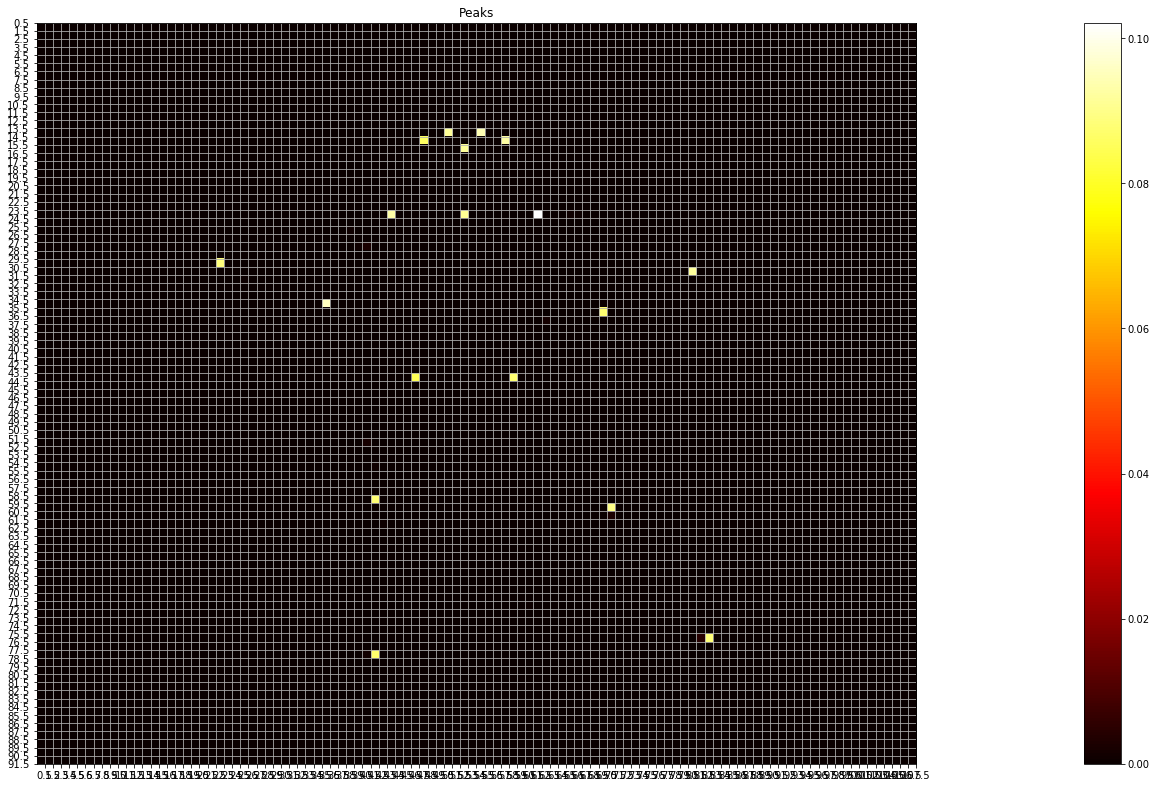

In [14]:
print(e.peaks.shape)
# show network output
peaks = np.amax(e.peaks[:, :, :-1], axis=2)
fig = plt.figure(figsize=(60, 30))
ax = fig.add_subplot(2, 1, 1)

heat_image = ax.imshow(peaks, cmap=plt.cm.hot)
ax.set_title('Peaks')

x_ticks = np.arange(0.5, e.peaks.shape[0], 1)
y_ticks = np.arange(0.5, e.peaks.shape[1], 1)

ax.set_xticks(y_ticks)
ax.set_yticks(x_ticks)

ax.grid()
fig.colorbar(heat_image, ax=ax, shrink=1.0)


In [ ]:
tmp = peaks > 0.05
cv2.imwrite("../results/plots/muscel_peaks.png", tmp * 255)

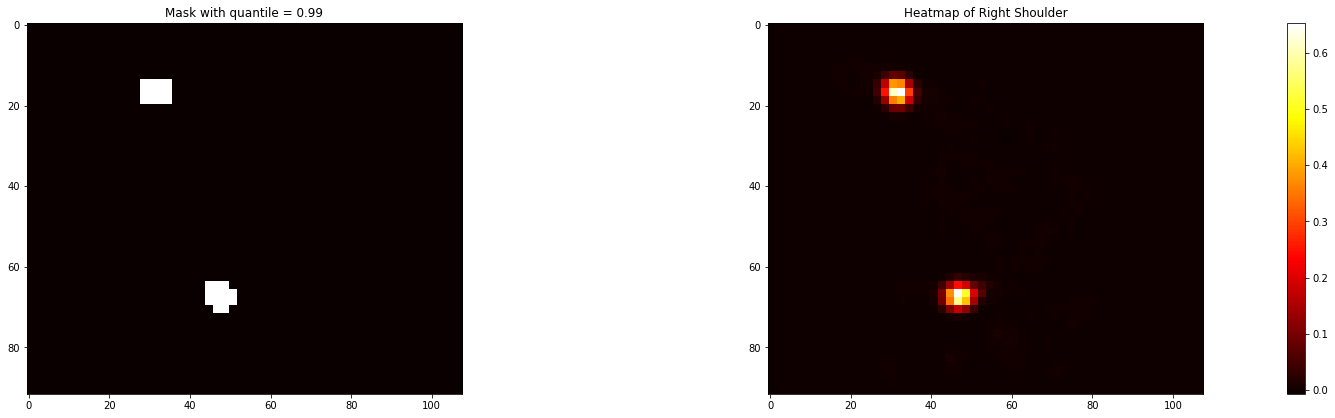

In [59]:

heatmap = e.heatMat[:, :, ATTRIBUTION_PART]
quantile = 0.99
quant = np.quantile(heatmap, quantile)
mask = heatmap > quant

# show network output
fig = plt.figure(figsize=(30, 15))
ax = fig.add_subplot(2, 1, 1)

heat_image = ax.imshow(heatmap, cmap=plt.cm.hot)
ax.set_title('Heatmap of Right Shoulder')
fig.colorbar(heat_image, ax=ax, shrink=1.0)

ax = fig.add_subplot(2, 2, 1)
ax.set_title(f'Mask with quantile = {quantile}')
ax.imshow(mask, cmap=plt.cm.hot)

In [60]:
x, y = np.unravel_index(heatmap.argmax(), heatmap.shape)
print(f'Max value {heatmap[x, y]} at ({x}, {y})')
print(np.sum(heatmap))
print(e.heatMat.shape, str(type(e.heatMat)))
print(e.pafMat.shape, str(type(e.pafMat)))

print(e.tensor_output.shape, str(type(e.tensor_output)))
print(e.tensor_image.shape, str(type(e.tensor_image)))
print(mask.shape)

Max value 0.653361976146698 at (66, 46)
39.928036
(92, 108, 19) <class 'numpy.ndarray'>
(92, 108, 38) <class 'numpy.ndarray'>
(?, ?, ?, 57) <class 'tensorflow.python.framework.ops.Tensor'>
(?, ?, ?, 3) <class 'tensorflow.python.framework.ops.Tensor'>
(92, 108)


In [68]:
# get the current session
sess = e.persistent_sess
# tf.reset_default_graph()
#sess = tf.Session()
LOGDIR = '../logs/openPose'

# Since we will explain it, the model has to be wrapped in a DeepExplain context
with DeepExplain(session=sess, graph=e.graph) as de:
    train_writer = tf.summary.FileWriter(LOGDIR)
    train_writer.add_graph(e.graph)

    input_tensor = e.tensor_image
    # output_tensor = e.tensor_heatMat[:, x, y, CocoPart.RShoulder.value] # DOES NOT WORK
    output_tensor = e.tensor_heatMat[:, :, :, ATTRIBUTION_PART]
    xs = tf.expand_dims(image, 0).eval(session=sess)
    xs = xs.astype('float64')
    # print(output_tensor.shape, str(type(output_tensor)))
    # print(input_tensor.shape, str(type(input_tensor)))
    # print(xs.shape, str(type(xs)))
    # Y_shape=[None] + list(xs.shape[1:])
    Y_shape = [None] + [1, 46, 54]  # size of heatmaps with resize
    # ys = np.ones([1,] + Y_shape[1:])
    heatmap = e.heatMat[:, :, ATTRIBUTION_PART]
    quantile = 0.995
    quant = np.quantile(heatmap, quantile)
    mask = heatmap > quant
#     mask = np.ones(e.heatMat[:, :, ATTRIBUTION_PART].shape)
    ys = np.expand_dims(np.expand_dims(mask, axis=0), axis=0)
    # print(Y_shape)
    baseline = np.zeros(list(xs.shape)[1:])  # baseline to compare against

    attributions = {
        # Gradient-based
        # NOTE: reduce_max is used to select the output unit for the class predicted by the classifier
        # For an example of how to use the ground-truth labels instead, see mnist_cnn_keras notebook
        # 'Integrated Gradients': de.explain('intgrad',  T=output_tensor, X=input_tensor, xs=xs, Y_shape=Y_shape, baseline=baseline),
        # 'Epsilon-LRP':          de.explain('elrp', T=output_tensor, X=input_tensor, xs=xs, Y_shape=Y_shape),
        # 'DeepLIFT (Rescale)':   de.explain('deeplift', T=output_tensor, X=input_tensor, xs=xs, Y_shape=Y_shape, baseline=baseline),
        # takes 4 hours and does not really work
        # 'Occlusion [15x15]':    de.explain('occlusion', T=output_tensor, X=input_tensor, xs=xs, Y_shape=Y_shape, window_shape=(15,15,3), step=4),
        # not feasable for that size of input
        # 'Shapley Sampling':     de.explain('shapley_sampling', T=output_tensor, X=input_tensor, xs=xs, Y_shape=Y_shape),
        'Saliency maps':        de.explain('saliency', T=output_tensor, X=input_tensor, xs=xs, ys=ys, Y_shape=Y_shape),
        'Gradient * Input':     de.explain('grad*input', T=output_tensor, X=input_tensor, xs=xs, ys=ys, Y_shape=Y_shape),
    }

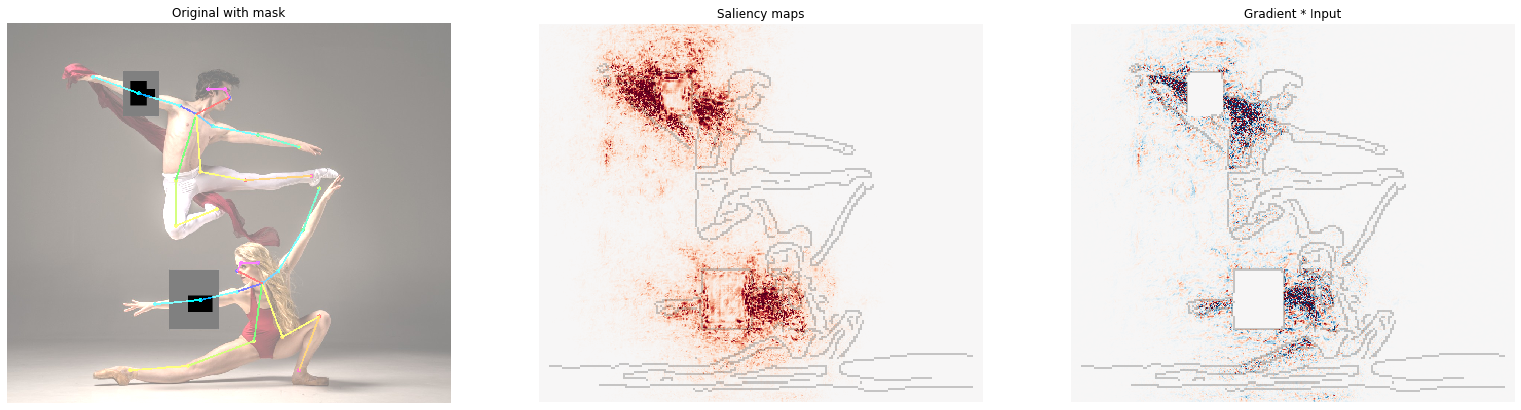

In [73]:
# Plot attributions
%matplotlib inline

n_cols = int(len(attributions)) + 1
n_rows = len(xs)
fig_scale = 3
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(
    3*n_cols*fig_scale, 3*n_rows*fig_scale))

for i, xi in enumerate(xs):
    
    ax = axes.flatten()[i*n_cols]
    inverted_mask = np.ones(mask.shape) - mask
    three_channel_mask = np.repeat(inverted_mask[..., np.newaxis], 3, 2).astype(np.float32) * 128
    resize_mask = cv2.resize(three_channel_mask, dsize=(image_orig_size.shape[1], image_orig_size.shape[0]), interpolation=cv2.INTER_AREA)
    

    image_result = TfPoseEstimator.draw_humans(image_orig_size, humans_orig, imgcopy=True)
    plot_image = np.clip(image_result + resize_mask, 0, 255)
    ax.imshow(cv2.cvtColor((plot_image / 255.0).astype(np.float32), cv2.COLOR_BGR2RGB))
    ax.set_title('Original with mask')
    ax.axis('off')
    xi = (xi - np.min(xi))
    xi /= np.max(xi)
    for j, a in enumerate(attributions):
        axj = axes.flatten()[i*n_cols + j + 1]
        plot(attributions[a][i], xi=xi, axis=axj,
             dilation=.5, percentile=99, alpha=.2).set_title(a)
        
fig.savefig('../results/plots/ballet_with_attr_occ.png', dpi=300, bbox_inches='tight')

In [6]:
upsample_size = np.array([int(e.target_size[1] / 8 * resize_out_ratio),
                 int(e.target_size[0] / 8 * resize_out_ratio)])
[target_np] = e.persistent_sess.run(
    [e.tensor_output],
    feed_dict={
        e.tensor_image: [image],
        e.upsample_size: upsample_size
    }
)

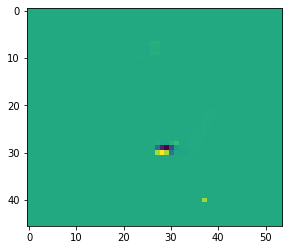

In [15]:
plt.imshow(target_np[0,:,:, 56])